## Full likelihood

In this notebook we show some example syntax for the new 'full likelihood'. The `likelihood` object remains pretty much the same, but here we use a new `FullTheory` object that replaces `LyaTheory` which deals with the mapping from a set of likelihood parameters (`like_params=[..]`) to a set of emulator calls and a $P_{1\rm{D}}$ in velocity units. The `FullTheory` object works in Planck units, i.e. $\omega_b^2$, $\omega_c^2$, $A_s$, $n_s$ so far, we can add more later on. It uses `CAMB` to map these parameters directly into a set of emulator calls $\Delta^2_p$, $n_p$, etc at each $z$ where we have data.

NB that there is a bit of duplicate code in this iteration which can be tidied up eventually, in that the syntax I use to fit the emulator calls is also found in `fit_linP`, however there the comoving linear power is calculated at each $z$ independently, and I thought it might be faster to give all $z$s to `CAMB` to calculate at once. If it is faster this way, this will matter when it comes to sampling. The other point to note is that I do not currently calculate $f_p$, which is done in the `fit_linP` fits, and I do that as we have not yet trained the emulator on it so I do not yet want to slow down likelihood evaluations calculating an expensive quantitity that is not used.

Also to avoid calling `CAMB` twice in different parts of the code, `get_emulator_calls()` now also has an option `return_M_of_z` which will give $M(z)$ for each emulator call, which is then used to convert the comoving $P_{1\rm{D}}$ into velocity units.

First we set up a `data` object and an emulator as normal.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import full_theory
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


Setup new theory object, interface between CAMB, IGM theories and the emulator

In [5]:
## Here we create our new theory object
theory=full_theory.FullTheory(zs=data.z,emulator=emu)

Note: redshifts have been re-sorted (earliest first)


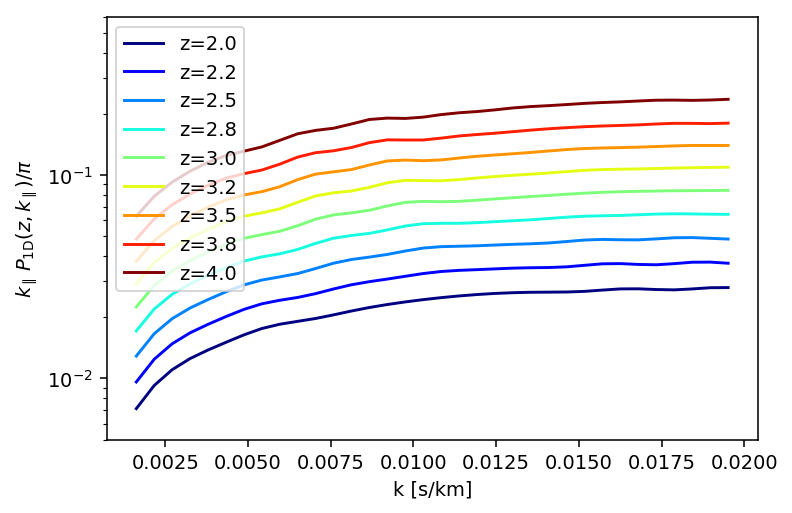

In [6]:
## Plot the fiducial P1D
theory.plot_p1d(data.k)

Show that our emulator calls are changing when we change some likelihood parameters

In [7]:
# get parameter values in input cosmology
like_param_list=theory.get_parameters()
# modify parameters
like_param_list[0].value=0.019 ## Change ombh2 from 0.022 to 0.019
like_param_list[2].value=1.9e-9 ## Change As from 2.1 to 1.9 e-9
like_param_list[3].value=0.92 ## Change ns from 0.965 to 0.96

In [8]:
emu_calls_fid=theory.get_emulator_calls(like_params=[],return_M_of_z=False)
emu_calls_modified=theory.get_emulator_calls(like_params=like_param_list,return_M_of_z=False)
print("z=2 emulator calls for fiducial = ", emu_calls_fid[0])
print("z=2 emulator calls after modifying = ", emu_calls_modified[0])

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
z=2 emulator calls for fiducial =  {'Delta2_p': 0.6300510342450939, 'n_p': -2.299445461757138, 'alpha_p': -0.2165269830826664, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls after modifying =  {'Delta2_p': 0.5399184497092127, 'n_p': -2.3437864627724245, 'alpha_p': -0.21744466797423617, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13203454194924402, 'kF_Mpc': 9.147325604109446}


So we can see that the cosmology-related emulator parameters change in a way that appears to make sense, and it looks like things are working ok. Next step is to set up a likelihood object using this new `FullTheory`, and try get some `log_probs` as a function of changing Planck parameters

In [9]:
## Try setting up a likelihood object with the new theory object
free_params=["ombh2","omch2","As"]
full_like=likelihood.Likelihood(data=data,theory=theory,
                            free_parameters=free_params,
                            free_param_limits=None,
                            verbose=True,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

likelihood setup with 3 free parameters
3 free parameters


In [10]:
full_like.log_prob(values=[0.52,0.55,0.45]) ## Evaluate a random log prob

Note: redshifts have been re-sorted (earliest first)
got P1D from emulator
compute chi2 for z=2.0
added 14.507180769735639 to log_like
compute chi2 for z=2.25
added 13.70045051424127 to log_like
compute chi2 for z=2.5
added 17.708547173874067 to log_like
compute chi2 for z=2.75
added 24.734035493768825 to log_like
compute chi2 for z=3.0
added 22.710514668407335 to log_like
compute chi2 for z=3.25
added 19.95405660561876 to log_like
compute chi2 for z=3.5
added 14.468593883892446 to log_like
compute chi2 for z=3.75
added -6.900740045786369 to log_like
compute chi2 for z=4.0
added -21.770432390166146 to log_like


98.54776222914138